<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: аналитик-разработчик в команде Яндекс.Метрики Мария Мансурова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 9
## <center> Анализ временных рядов

In [1]:
import numpy as np
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater

init_notebook_mode(connected = True)


def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

2.0.8


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [2]:
df = pd.read_csv('../../data/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

In [4]:
df.date = pd.to_datetime(df.date)

In [ ]:
plotly_df(df.set_index('date')[['count']])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [6]:
from fbprophet import Prophet

In [7]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()

In [8]:
prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True)
prophet.fit(train_df);

In [9]:
future = prophet.make_future_dataframe(periods=predictions)
forecast = prophet.predict(future);

**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

In [10]:
forecast[forecast["ds"] == pd.datetime(2016, 1, 20)]["yhat"].values[0]

3832.9666138975599

Оценим качество предсказания по последним 30 точкам.

In [11]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

**Вопрос 2**: Какое получилось MAPE?

**Вопрос 3**: Какое получилось MAE?

In [12]:
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100 * cmp_df['e'] / cmp_df['y']
print('MAPE:', np.mean(abs(cmp_df[-predictions:]['p'])))
print('MAE: ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE: 38.38827176223028
MAE:  713.0110429704669


## Предсказываем с помощью ARIMA

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as smt

/home/mikhaildubov/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

In [14]:
# H_0: The series is NOT stationary
# No idea why we should take just 'train_df', but in this way we can get the desired answer
print("p-value: ", sm.tsa.stattools.adfuller(train_df["y"].values)[1])

p-value:  0.107392196276


**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

In [15]:
data = train_df.copy().reset_index(drop=True)

In [16]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

Критерий Дики-Фуллера: p=0.107392


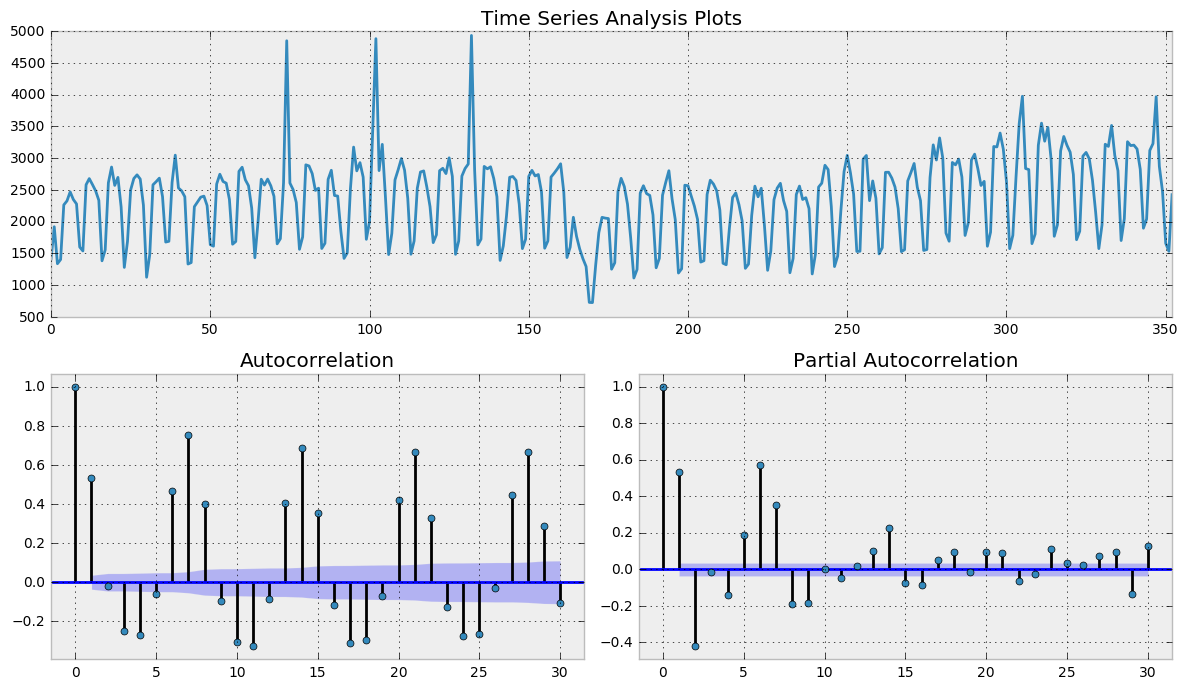

In [17]:
tsplot(data["y"], lags=30)

In [18]:
season_period = 7  # Clearly seen from the graph above

In [19]:
data["y_season"] = data["y"] - data["y"].shift(season_period)

Критерий Дики-Фуллера: p=0.000000


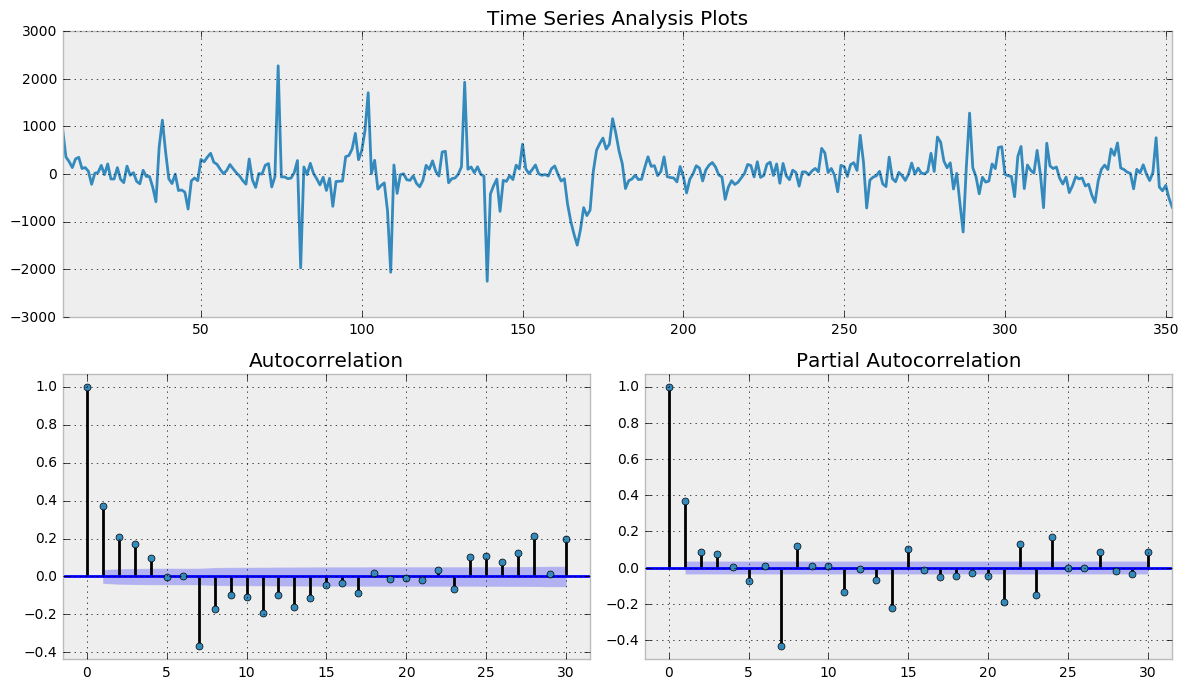

In [20]:
tsplot(data["y_season"][season_period:], lags=30)  # Low p-value in the Dickey–Fuller test! => Stationary now

In [21]:
# We have found out that seasonality=7 works good, let's use it in the SARIMAX models we are going to build
possible_params = [
    {"D": 1, "d": 0, "Q": 0, "q": 2, "P": 3, "p": 1},
    {"D": 2, "d": 1, "Q": 1, "q": 2, "P": 3, "p": 1},
    {"D": 1, "d": 1, "Q": 1, "q": 2, "P": 3, "p": 1},
    {"D": 0, "d": 0, "Q": 0, "q": 2, "P": 3, "p": 1},
]

In [22]:
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [33]:
results = []
best_aic = float("inf")

for params in tqdm(possible_params):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=SARIMAX(df["y"].values, order=(params["p"], params["d"], params["q"]), 
                      seasonal_order=(params["P"], params["D"], params["Q"], season_period)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', params)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_params = params
    results.append([params, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

 25%|██▌       | 1/4 [00:03<00:09,  3.06s/it]/home/mikhaildubov/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

100%|██████████| 4/4 [00:23<00:00,  5.97s/it]

wrong parameters: {'D': 0, 'Q': 0, 'd': 0, 'P': 3, 'p': 1, 'q': 2}
                                         parameters          aic
0  {'D': 1, 'Q': 0, 'd': 0, 'P': 3, 'p': 1, 'q': 2}  5476.002527
2  {'D': 1, 'Q': 1, 'd': 1, 'P': 3, 'p': 1, 'q': 2}  5478.516679
1  {'D': 2, 'Q': 1, 'd': 1, 'P': 3, 'p': 1, 'q': 2}  5480.237652
